In [1]:
import numpy as np

***
## Configuration
***

In [2]:
# PARAMETERS
# Modify this section to adjust the classifier's behavior.
shots = 8192
dataset_size = 600 + 300
training_size = 600/dataset_size
n_trash_qubits = 2

batch_size = 25
epochs = 50
iters = 4000 # int((dataset_size * training_size * epochs) / batch_size)

In [3]:
int((dataset_size * training_size * epochs) / batch_size)

1200

In [4]:
# SIMULATION CONFIG
# Modify this section to change the type of simulation used.
from qiskit_aer import AerSimulator
# from qiskit_aer.noise import NoiseModel
# from qiskit_ibm_runtime.fake_provider import FakeNairobiV2

# noise_model = NoiseModel.from_backend(FakeNairobiV2())
# backend = AerSimulator(noise_model=noise_model)
backend = AerSimulator()

***
## Dataset
***

In [5]:
from credit_card import load_fraud_dataset

features, labels = load_fraud_dataset(dataset_size, 42, False)

feature_dim = len(features[0])
n_qubits = int(np.ceil(np.log2(feature_dim)))

***
## Experiment
***

In [6]:
from qiskit.circuit.library import StatePreparation

import warnings
warnings.simplefilter('ignore')

from credit_card import configure_compressor, extract_features, training, testing

def full_experiment(target_class, n_trash_partition, reps=1):

    print('configuring compressor...')

    # 1. CONFIGURE COMPRESSOR
    compressor = configure_compressor(
        features, labels, target_class, n_qubits, n_trash_partition, training_size, backend, verbose=1
    )

    print('extracting features...')

    # 2. CREATE DATASETS FROM EXTRACTED FEATURES (TRASH DATA)
    train_data, train_targets, test_data, test_targets = extract_features(
        features, labels, target_class, compressor, n_qubits, training_size, backend, shots, initializer, opt_params, verbose=0
    )

    # print(train_targets)
    # train_targets = np.array(train_targets)
    # indexes = np.where(train_targets < 1)
    # train_data = np.array(train_data)
    
    # train_data = train_data[indexes]
    # train_targets = train_targets[indexes]

    # print(indexes)
    # print(train_targets.shape)
    # print(train_targets)

    print('training and testing...')

    # REPEAT TRAINING AND TESTING PROCESS `reps` TIMES
    metrics = ([],[],[],[],[],[],[],[],[],[],[])

    print(f'\trep:', end='')
    for rep in range(reps):
        print(f' {rep} ', end='')

        # 3. TRAINING
        model = training(train_data, train_targets, iters, batch_size, verbose=0)

        # 4. TESTING
        total_loss, tp, tn, acc, fp, fn, f1, mcc, scores, auc = testing(model, test_data, test_targets, verbose=0)

        # SAVES TESTING RESULTS FOR EACH `rep`
        metrics[0].append(sum(total_loss))
        metrics[1].append(tp)
        metrics[2].append(tn)
        metrics[3].append(acc)
        metrics[4].append(fp)
        metrics[5].append(fn)
        metrics[6].append(f1)
        metrics[7].append(mcc)
        metrics[8].append(scores)
        metrics[9].append(test_targets)
        metrics[10].append(auc)

    print()

    return metrics


results = {}
target_class = 0
for max_fidelity_loss in [0.0]: #, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.60, 1.0]:
    print('max_fidelity_loss:', max_fidelity_loss)

    if max_fidelity_loss == 0.0:
        opt_params = None
        initializer = StatePreparation
    else:
        from qclib.state_preparation import BaaLowRankInitialize
        opt_params = {
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': 'brute_force',
            'use_low_rank': True
        }
        initializer = BaaLowRankInitialize

    results[max_fidelity_loss] = full_experiment(target_class, n_trash_partition=n_trash_qubits, reps=10)

max_fidelity_loss: 0.0
configuring compressor...
	trash qubits: 2
	trash_partition: [0, 1]
	compressor depth: 30
	compressor cnots: 18
extracting features...
training and testing...
	rep: 0  1  2  3  4  5  6  7  8  9 


In [7]:
from credit_card import display_results
display_results(results)

| max loss | avg. TP | std. TP | avg. TN | std. TN | avg. FP | std. FP | avg. FN | std. FN | avg. acc | std. acc | avg. F1 | std. F1 | avg. MCC | std. MCC | avg. AUC | std. AUC |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| 0.0 | 135.6 | 5.0833 | 117.6 | 2.7641 | 32.4 | 2.7641 | 14.4 | 5.0833 | 0.844 | 0.0093 | 0.8526 | 0.012 | 0.6941 | 0.0223 | 0.9069 | 0.0007 |


max_fidelity_loss: 0.0
MAX. AUC: 0.9082222222222222


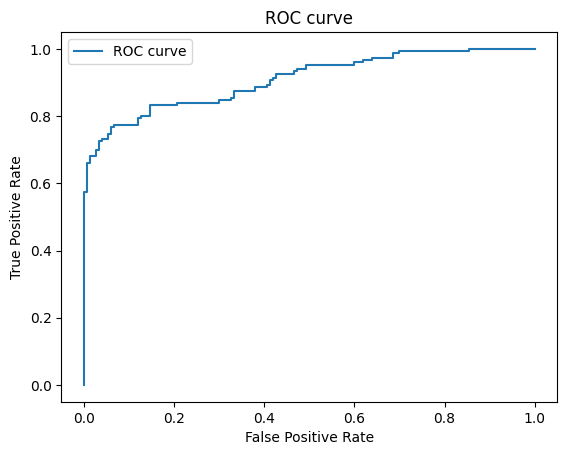

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

for max_fidelity_loss, result in results.items():
    auc_max = max(result[10])
    auc_index = result[10].index(auc_max)
    scores = result[8][auc_index]
    y_test = result[9][auc_index]
    fprs, tprs, _ = roc_curve(y_test, scores)

    print('max_fidelity_loss:', max_fidelity_loss)
    print('MAX. AUC:', auc_max)
    plot_roc(fprs, tprs)